# Face Generation using Pytorch Pre-trained Model

Pytorch Hub is a pre-trained model repository designed to facilitate research reproducibility. 

Using TorchNet in Analytics-Zoo, we can easily load these pre-trained model and make a distributed inference with only a few lines of code change.

Here is an easy example of loading Pytorch pretrained [Progressive Growing of GANs (PGAN)](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub to Analytics-Zoo, and generate faces in distributed mode on Spark. We just make a little change of the pytorch prediction example code in sector 1.

## 1. Pytorch's example
This sector will show you how pytorch run the generation. The code in this sector is copied from [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/).  
The next sector will show you how to run a distributed generation using Analytics-Zoo and Spark.

### Load pretrained model from Pytorch Hub
Load [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub.
This PGAN model trained on high-quality celebrity faces "celebA" dataset, and will output 512 x 512 pixel images

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [3]:
import torch

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Using cache found in /home/xin/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


### Generate noise with model's build-in method

In [4]:
num_images = 64
noise, _ = model.buildNoiseData(num_images)

### Run Generation in Pytorch

In [5]:
with torch.no_grad():
    generated_images = model.test(noise)

### Show Image with Matplotlib and Torchvision

In [6]:
import torchvision
grid = torchvision.utils.make_grid(torch.Tensor(generated_images).clamp(min=-1, max=1), scale_each=True, normalize=True)

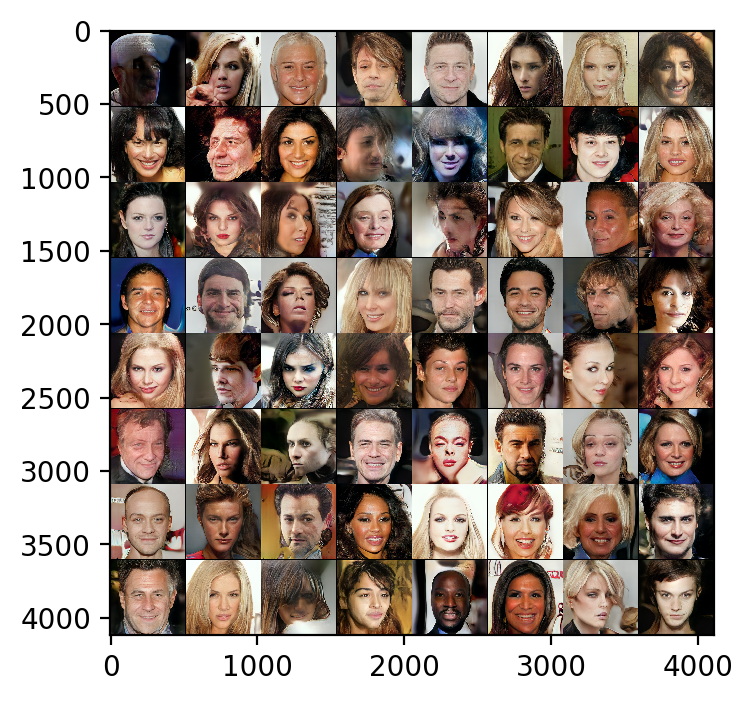

In [7]:
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## 2. Run Distributed Generation on Spark using TorchNet
This sector will show you how to load a pretrained pytorch model to Analytics-Zoo, and run generation in distributed mode.

### Initialize Analytics-Zoo

In [8]:
from zoo.common.nncontext import init_spark_on_local, init_spark_on_yarn, init_nncontext
from zoo.pipeline.api.torch import TorchModel
import numpy as np
import os
hadoop_conf_dir = os.environ.get('HADOOP_CONF_DIR')
                                 
if 'sc' in dir():
    sc = init_nncontext()
else:
    sc = init_spark_on_local(cores = 4, conf = {"spark.driver.memory": "10g"})

/opt/anaconda3/envs/test/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /opt/spark/latest, and pyspark is found in: /opt/anaconda3/envs/test/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)
/opt/anaconda3/envs/test/lib/python3.6/site-packages/zoo/util/engine.py:42: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /opt/spark/latest, and pyspark is found in: /opt/anaconda3/envs/test/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, you are recommended to use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.

Prepending /opt/anaconda3/envs/test/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /opt/anaconda3/envs/test/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.11.1-spark_2.4.3-0.9.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /opt/anaconda3/envs/test/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
WARN: detect python < 3.7, if you meet zlib not available exception on yarn, please update your python to 3.7
WARN: detect python < 3.7, if you meet zlib not available exception on yarn, please update your python to 3.7
Current pyspark location is : /opt/anaconda3/envs/test/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /opt/anaconda3/envs/test/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.11.1-spark_2.4.3-0.9.0-SNAPSHOT-jar-with-dependencies.jar:/opt/anaconda3/envs/test/lib/python3.6/site-packages/bigd

### Construct noise RDD
Parallelize noise samples to spark RDD.

In [9]:
from zoo.common import Sample
noiseSamples = np.vsplit(noise.numpy(), num_images)
noiseRdd = sc.parallelize(noiseSamples).map(lambda n: Sample.from_ndarray(n.reshape(512), np.zeros(1)))

### Load Generation Network to TorchNet

In [10]:
from zoo.pipeline.api.torch import TorchModel
def get_netG():
    model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)
    return model.netG
    

net = TorchModel.from_pytorch(get_netG)

Using cache found in /home/xin/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !
creating: createTorchModel


### Run Generation in Distributed Mode
Just set distributed to true, the prediction will run on Spark.
The parameter batch_per_thread means how many noise data will be processed once in a thread. The total thread number is your total spark cores.

In [11]:
dist_result = net.predict(noiseRdd, batch_size=16)
dist_generated_images = dist_result.collect()

### Show Image with Matplotlib and Torchvision
As __dist_generated_images__ is a list of ndarray, we need to concate them into a single ndarray.

In [12]:
dist_generated_images = np.stack(dist_generated_images)
dist_grid = torchvision.utils.make_grid(torch.Tensor(dist_generated_images).clamp(min=-1, max=1),
                                        scale_each=True, normalize=True)

The generated images are the same but our of order with pytorch's generation, due to the repartition(better performance) when we construct noise RDD. If you remove the repartition, this result will be exactly the same.

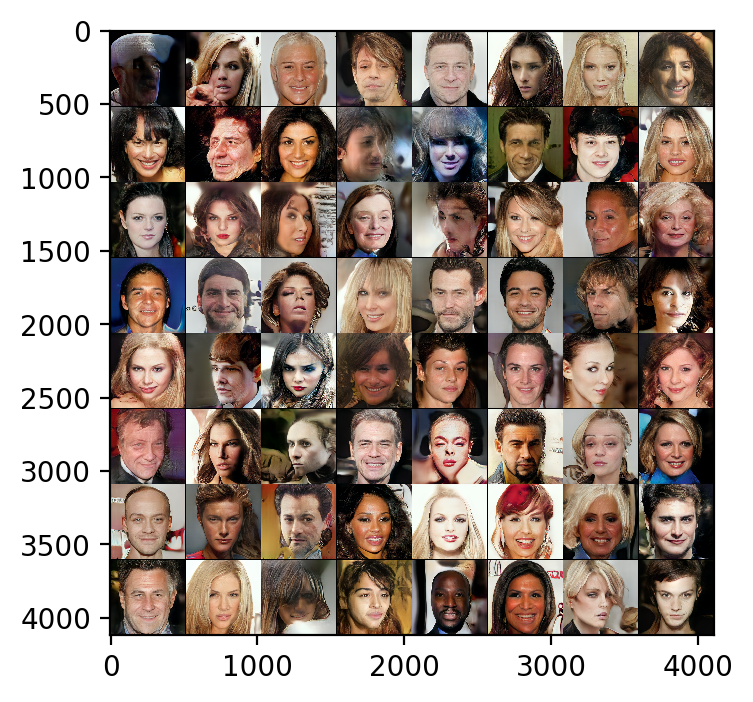

In [13]:
plt.imshow(dist_grid.permute(1, 2, 0).cpu().numpy())
plt.show()